In [4]:
# Make sure all necessary imports are included
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output

from games import TicTacToe

In [56]:
# Implementing a simple policy network for tic tac toe that outputs a probability distribution over all legal moves

class SimplePolicyNetwork(nn.Module):
    def __init__(self, board_size, num_moves):
        """
        Initializes the Policy Network.
        :param board_size: Tuple of the board dimensions, e.g., (19, 19) for Go.
        :param num_moves: Total number of possible moves in the game.
        """
        super(SimplePolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc = nn.Linear(128 * board_size[0] * board_size[1], num_moves)

    def forward(self, x):
        """
        Forward pass of the network.
        :param x: Input tensor, the game state.
        :return: Probability distribution over all possible moves.
        """
        # Apply two convolutional layers with ReLU activations
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        # Output layer with a softmax to get probabilities
        x = self.fc(x)
        return F.softmax(x, dim=1)


# Example usage
board_size = (3, 3)  # For Tic Tac Toe
num_moves = board_size[0] * board_size[1]  # Assuming each cell is a possible move
model = SimplePolicyNetwork(board_size, num_moves)

# Example input: a single game state, with 1 channel, and 19x19 board size
# The input should be a 4D tensor: [batch_size, channels, height, width]
# Here, batch_size = 1, channels = 1 (just the board, could be more for different game states)
game_state = torch.randn(1, 1, board_size[0], board_size[1])
# Get the probability distribution over moves
probabilities = model(game_state)

print(probabilities)  # Each element corresponds to the probability of a move being the best next move

def sample_valid_move(probabilities, valid_moves_indices):
    """
    Samples a move from the probability distribution over moves, ensuring it is a valid move.
    :param probabilities: A tensor of probabilities for each move.
    :param valid_moves_indices: A list of indices representing valid moves.
    :return: An index representing the selected move.
    """
    # Create a mask to zero out probabilities of invalid moves
    mask = torch.zeros_like(probabilities)
    mask[0, valid_moves_indices] = 1
    
    # Apply the mask to the probabilities
    masked_probabilities = probabilities * mask
    
    # Renormalize the probabilities to sum to 1
    masked_probabilities /= torch.sum(masked_probabilities)
    
    # Sample a move from the renormalized probability distribution
    move_index = torch.multinomial(masked_probabilities, 1).item()
    return move_index


tensor([[0.1153, 0.1081, 0.1132, 0.1126, 0.1082, 0.1036, 0.1103, 0.1130, 0.1157]],
       grad_fn=<SoftmaxBackward0>)


In [6]:
def convert_board_to_input(board):
    """
    Convert the game board to a tensor suitable for the policy network.
    The input is a 4D tensor: [batch_size, channels, height, width].
    """
    # Convert the board to a tensor with shape (1, 1, 3, 3)
    # 1 channel, the board's state is represented in a 3x3 grid
    board_tensor = torch.tensor(board, dtype=torch.float).unsqueeze(0).unsqueeze(0)
    return board_tensor

def select_move(probabilities, valid_moves_indices):
    """
    Select the move with the highest probability that is also a valid move.
    """
    # Zero out the probabilities of moves that are not valid
    prob_masked = probabilities.clone().detach()
    prob_masked[0, np.setdiff1d(np.arange(num_moves), valid_moves_indices)] = 0
    # Select the move with the highest probability
    move_index = torch.argmax(prob_masked).item()
    return move_index

# Initialize the TicTacToe game
game = TicTacToe()

# Initialize the policy network
model = SimplePolicyNetwork(board_size, num_moves)

# Play until the game is over
while not game.is_game_over():
    # Convert the current game state to a tensor input for the network
    current_state_tensor = convert_board_to_input(game.board)
    # Get the probability distribution over moves from the policy network
    probabilities = model(current_state_tensor)
    # Get valid move indices
    valid_moves_indices = game.get_valid_moves_indices()
    # Select the move with the highest probability among valid moves
    selected_move_index = select_move(probabilities, valid_moves_indices)
    # Make the move
    game.make_move_from_index(selected_move_index)
    # Print the board state
    print(game)
    print("------")

# Check the result
if game.winner:
    print(f"Player {game.winner} wins!")
else:
    print("It's a draw!")

[[0 0 0]
 [0 0 1]
 [0 0 0]]
------
[[0 0 0]
 [0 0 1]
 [0 2 0]]
------
[[0 0 1]
 [0 0 1]
 [0 2 0]]
------
[[0 0 1]
 [0 0 1]
 [0 2 2]]
------
[[0 1 1]
 [0 0 1]
 [0 2 2]]
------
[[0 1 1]
 [2 0 1]
 [0 2 2]]
------
[[0 1 1]
 [2 0 1]
 [1 2 2]]
------
[[0 1 1]
 [2 2 1]
 [1 2 2]]
------
[[1 1 1]
 [2 2 1]
 [1 2 2]]
------
Player 1 wins!


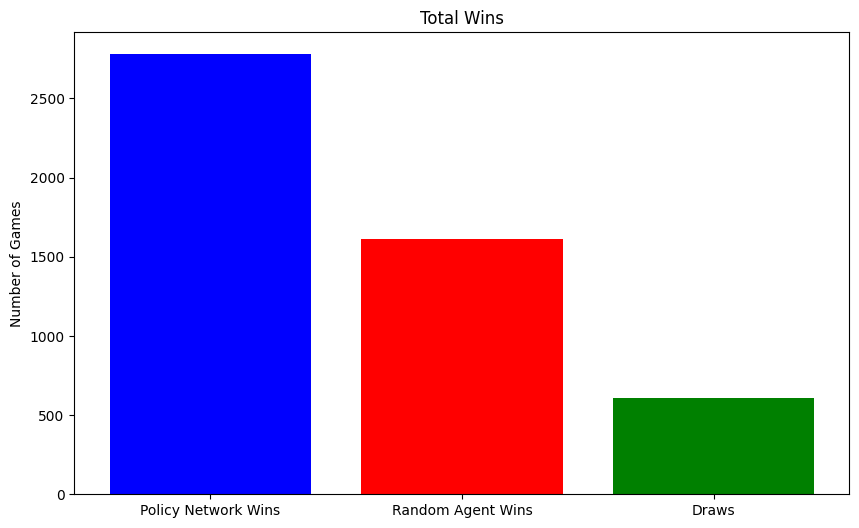

In [57]:
class RandomAgent:
    def __init__(self):
        pass

    def select_move(self, valid_moves_indices):
        """
        Selects a move randomly from the list of valid move indices.
        :param valid_moves_indices: A list of indices representing valid moves.
        :return: An index representing the selected move.
        """
        return random.choice(valid_moves_indices)

random_agent = RandomAgent()

# def play_game_with_random_old(policy_model, game, random_agent):
#     game.reset()
#     # Randomly choose which agent starts
#     # game.turn = random.choice([1, 2])
#     while not game.is_game_over():
#         if game.turn == 1:  # Policy network plays and is player 1
#             current_state_tensor = convert_board_to_input(game.board)
#             probabilities = policy_model(current_state_tensor)
#             valid_moves_indices = game.get_valid_moves_indices()
#             selected_move_index = select_move(probabilities, valid_moves_indices)
#             game.make_move_from_index(selected_move_index)
#         else:  # Random agent's turn
#             valid_moves_indices = game.get_valid_moves_indices()
#             selected_move_index = random_agent.select_move(valid_moves_indices)
#             game.make_move_from_index(selected_move_index)
#     return game.winner # return 1 if first player to play won

game = TicTacToe()
def play_game_with_random(policy_model, game):
    game = TicTacToe() # weird bug where reset doesn't work but redeclaring the object does
    # game.reset()
    while not game.is_game_over():
        if game.turn == 1:  # Policy network's turn
            # state = convert_board_to_input(game.board)
            # probs = policy_model(state)
            # action = torch.multinomial(probs, 1).item()  # Sample action
            # # action = torch.argmax(probs).item()
            # game.make_move_from_index(action)
            current_state_tensor = convert_board_to_input(game.board)
            probabilities = policy_model(current_state_tensor)
            valid_moves_indices = game.get_valid_moves_indices()
            selected_move_index = select_move(probabilities, valid_moves_indices)
            game.make_move_from_index(selected_move_index)
        else:  # Random agent's turn
            valid_moves = game.get_valid_moves_indices()
            action = np.random.choice(valid_moves)
            game.make_move_from_index(action)
    # print(game.board)
    return (game.winner, game.board)


wins = {1: 0, 2: 0, 0: 0}  # 1: Policy Network, 2: Random Agent, 0: Draw
num_simulations = 5000

model = SimplePolicyNetwork(board_size, num_moves)
boards = []
for _ in range(num_simulations):
    winner,board = play_game_with_random(model, game)
    wins[winner] += 1
    boards.append(board)
    # game.reset()  # Reset the game to its initial state after each simulation


# Plotting win rates
labels = ['Policy Network Wins', 'Random Agent Wins', 'Draws']
values = [wins[1], wins[2], wins[0]]

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'red', 'green'])
plt.title('Total Wins')
plt.ylabel('Number of Games')
plt.show()


In [58]:
boards
game2 = TicTacToe()
game2.board
game2.reset
game2.is_game_over()

False

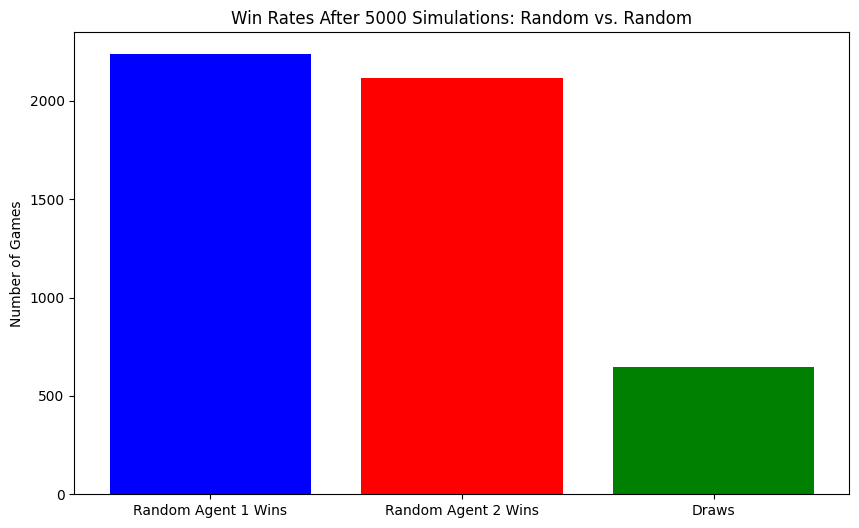

In [9]:
# Defining a function to simulate a game between two random agents
def play_game_random_vs_random(game, agent1, agent2):
    game = TicTacToe()
    # Randomly choose which agent starts
    game.turn = random.choice([1, 2])
    while not game.is_game_over():
        if game.turn == 1:  # Random agent 1's turn
            valid_moves_indices = game.get_valid_moves_indices()
            selected_move_index = agent1.select_move(valid_moves_indices)
            game.make_move_from_index(selected_move_index)
        else:  # Random agent 2's turn
            valid_moves_indices = game.get_valid_moves_indices()
            selected_move_index = agent2.select_move(valid_moves_indices)
            game.make_move_from_index(selected_move_index)
    return game.winner



# Initializing the game and two random agents
game = TicTacToe()
random_agent1 = RandomAgent()
random_agent2 = RandomAgent()

gameHistory = []

# Simulating games
wins_random_vs_random = {1: 0, 2: 0, 0: 0}  # 1: Random Agent 1, 2: Random Agent 2, 0: Draw
num_simulations_random_vs_random = 5000

for _ in range(num_simulations_random_vs_random):
    winner = play_game_random_vs_random(game, random_agent1, random_agent2)
    wins_random_vs_random[winner] += 1
    # Store a copy of the board's state and the winner at this point
    final_state = (np.copy(game.board), game.winner)
    gameHistory.append(final_state)
    game = TicTacToe()  # Reset the game to its initial state after each simulation

# Plotting win rates for games between two random agents
labels_random_vs_random = ['Random Agent 1 Wins', 'Random Agent 2 Wins', 'Draws']
values_random_vs_random = [wins_random_vs_random[1], wins_random_vs_random[2], wins_random_vs_random[0]]

plt.figure(figsize=(10, 6))
plt.bar(labels_random_vs_random, values_random_vs_random, color=['blue', 'red', 'green'])
plt.title('Win Rates After 5000 Simulations: Random vs. Random')
plt.ylabel('Number of Games')
plt.show()



In [10]:
def random_agent_benchmark(model, total_games=500):
    random_agent = RandomAgent()
    win_count = 0
    for _ in range(total_games):
        testGame = TicTacToe()
        winner, board = play_game_with_random(model, testGame)
        if winner == 1:
            win_count +=1
            boards.append(board)
    print(f"Win Rate: {win_count/total_games*100}%")
    return boards

def compute_returns(rewards, gamma=1.0):
    """
    Compute returns for each time step, given the rewards
    and a discount factor gamma.
    """
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return returns

# Initialize environment, policy network, and optimizer
game = TicTacToe()
policy_network = SimplePolicyNetwork(board_size=(3, 3), num_moves=9)
optimizer = optim.Adam(policy_network.parameters(), lr=0.001)

num_episodes = 10000


def get_reward(game):
    """
    Defines the reward for the policy network based on the game's outcome.
    Assume the policy network always plays as player 1.
    """
    if game.is_winner(1):  # Policy network wins
        return 1
    elif game.is_winner(2):  # Policy network loses
        return -1
    return 0  # No reward for intermediate moves


win_record = []
policy_losses = []  # Store policy losses for plotting
episode_rewards = []  # Average reward per episode

# Training loop
for episode in tqdm(range(num_episodes), desc="Processing Episodes"):
    saved_log_probs = []
    rewards = []
    game = TicTacToe()
    while not game.is_game_over():
        if game.turn == 1:  # Policy network's turn
            state = convert_board_to_input(game.board)
            probs = policy_network(state)
            action = torch.multinomial(probs, 1).item()  # Sample action
            saved_log_probs.append(torch.log(probs.squeeze(0)[action]))
            game.make_move_from_index(action)
        else:  # Random agent's turn
            valid_moves = game.get_valid_moves_indices()
            action = np.random.choice(valid_moves)
            game.make_move_from_index(action)
        reward = get_reward(game)  # Define a suitable reward function
        rewards.append(reward)
    
    # Compute returns
    returns = compute_returns(rewards)
    returns = torch.tensor(returns)

    # Determine the outcome of the episode
    win_record.append(game.winner)
    episode_rewards.append(np.mean(rewards))
    
    # Collect individual loss tensors in a list
    policy_loss_terms = []
    for log_prob, R in zip(saved_log_probs, returns):
        loss = -log_prob * R
        policy_loss_terms.append(loss.unsqueeze(0))

    # Concatenate and sum to compute the total policy loss for the episode
    total_policy_loss = torch.cat(policy_loss_terms).sum()
    policy_losses.append(total_policy_loss.item())  # Recording scalar loss

    # Use total_policy_loss for gradient computation
    optimizer.zero_grad()
    total_policy_loss.backward()
    optimizer.step()

    interval = num_episodes // 10
    if episode > 0 and (episode) % interval == 0:
        random_agent_benchmark(policy_network)
        avg_loss = np.mean(policy_losses[-100:])  # Average loss for the last 100 episodes
        print(f"Episode {episode + 1}: Average Loss = {avg_loss}")

Processing Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Win Rate: 73.4%
Episode 1001: Average Loss = 2.452171940803528
Win Rate: 97.8%
Episode 2001: Average Loss = 0.4126820011623204
Win Rate: 99.8%
Episode 3001: Average Loss = 0.17330179594137007
Win Rate: 99.6%
Episode 4001: Average Loss = 0.013660989056515973
Win Rate: 100.0%
Episode 5001: Average Loss = 0.0006943499361295835
Win Rate: 100.0%
Episode 6001: Average Loss = 0.00024733490625294507
Win Rate: 98.8%
Episode 7001: Average Loss = 0.023854185018717545
Win Rate: 98.6%
Episode 8001: Average Loss = 0.0687381313364358
Win Rate: 100.0%
Episode 9001: Average Loss = 0.00011240511436881206


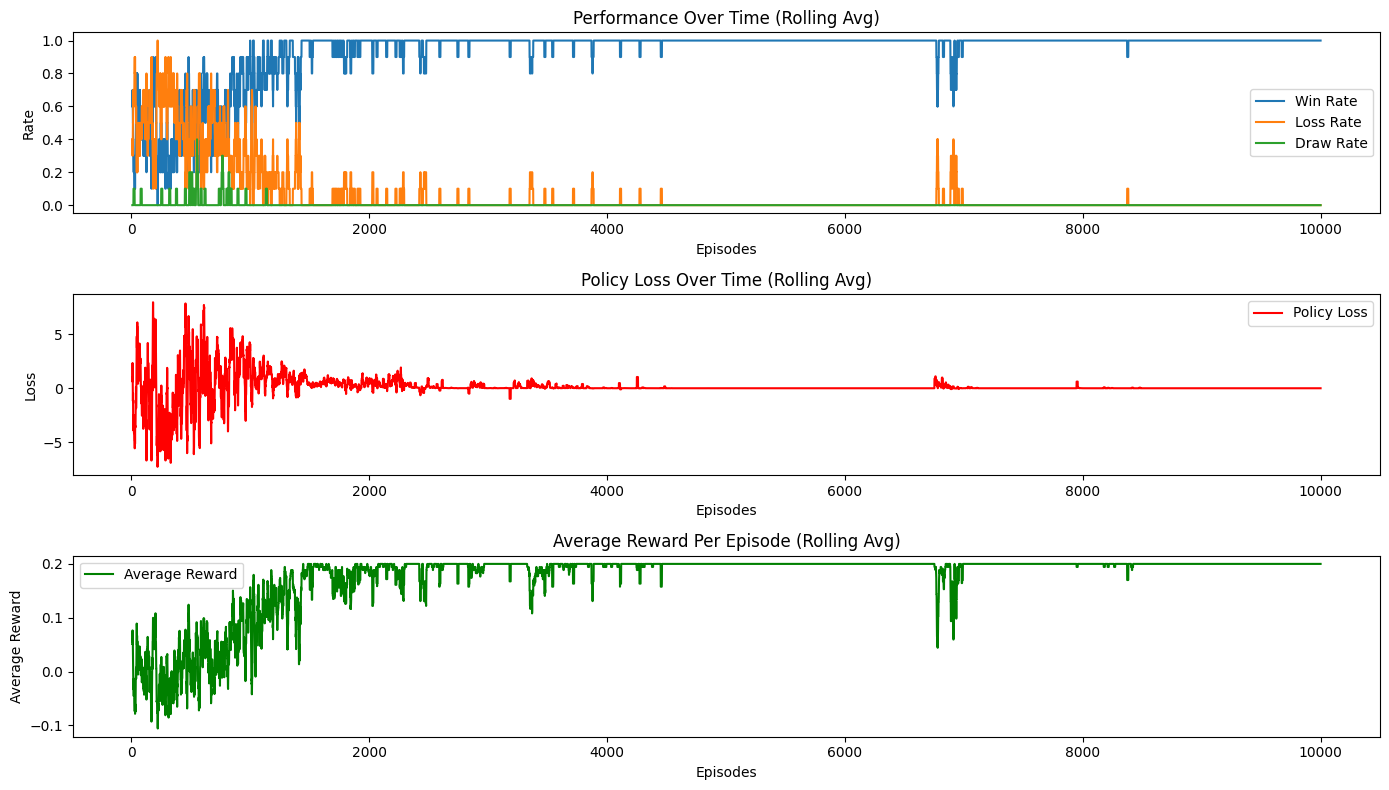

In [11]:
# Plotting results of training against a random agent

# Function to calculate rolling average using np.convolve
def calculate_rolling_average(data, window_size=10):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, 'valid')

# Convert win_record to binary for win, loss, and draw
wins_binary = (np.array(win_record) == 1).astype(float)
losses_binary = (np.array(win_record) == 2).astype(float)
draws_binary = (np.array(win_record) == 0).astype(float)

# Calculate rolling averages
rolling_avg_win_rate = calculate_rolling_average(wins_binary)
rolling_avg_loss_rate = calculate_rolling_average(losses_binary)
rolling_avg_draw_rate = calculate_rolling_average(draws_binary)
rolling_avg_policy_losses = calculate_rolling_average(policy_losses)
rolling_avg_episode_rewards = calculate_rolling_average(episode_rewards)

# Plotting
window_size = 10  # Adjust window_size if needed

plt.figure(figsize=(14, 8))

# Win, Loss, Draw Rates
plt.subplot(3, 1, 1)
episodes_adjusted = np.arange(window_size, len(win_record) + 1)
plt.plot(episodes_adjusted, rolling_avg_win_rate, label='Win Rate')
plt.plot(episodes_adjusted, rolling_avg_loss_rate, label='Loss Rate')
plt.plot(episodes_adjusted, rolling_avg_draw_rate, label='Draw Rate')
plt.xlabel('Episodes')
plt.ylabel('Rate')
plt.title('Performance Over Time (Rolling Avg)')
plt.legend()

# Policy Loss
plt.subplot(3, 1, 2)
plt.plot(episodes_adjusted, rolling_avg_policy_losses, label='Policy Loss', color='red')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Policy Loss Over Time (Rolling Avg)')
plt.legend()

# Average Rewards
plt.subplot(3, 1, 3)
plt.plot(episodes_adjusted, rolling_avg_episode_rewards, label='Average Reward', color='green')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward Per Episode (Rolling Avg)')
plt.legend()

plt.tight_layout()
plt.show()


In [45]:
# selfplay (current)

# debugging
game_log = []
# 
policy_network = SimplePolicyNetwork(board_size=(3, 3), num_moves=9)
optimizer = optim.Adam(policy_network.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)  # Adjust parameters as needed

def compute_returns(rewards, gamma=1.0):
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return returns

def self_play(episodes):
    policy_losses = []  # Initialize outside the loop if needed for tracking
    for episode in tqdm(range(episodes), desc="Self-Play Episodes"):
        game = TicTacToe()
        saved_log_probs = []
        rewards = []
        local_history = []

        while not game.is_game_over():
            # state = convert_board_to_input(game.board)
            # probs = policy_network(state)
            # action = torch.multinomial(probs, 1).item()
            # game.make_move_from_index(action)


            current_state_tensor = convert_board_to_input(game.board)
            probabilities = policy_network(current_state_tensor)
            valid_moves_indices = game.get_valid_moves_indices()
            selected_move_index = select_move(probabilities, valid_moves_indices)
            game.make_move_from_index(selected_move_index)

            reward = get_reward(game)
            saved_log_probs.append(torch.log(probabilities.squeeze(0)[selected_move_index]))
            rewards.append(reward)
            local_history.append(np.copy(game.board))


        game_log.append(local_history)

        # Compute returns and update the policy
        returns = compute_returns(rewards)
        returns = torch.tensor(returns, dtype=torch.float32)
        
        optimizer.zero_grad()
        policy_loss = -sum(log_prob * R for log_prob, R in zip(saved_log_probs, returns))
        policy_loss.backward()
        optimizer.step()
        lr_scheduler.step()  # Adjust learning rate

        policy_losses.append(policy_loss.item())

        interval = episodes // 10
        if episode > 0 and (episode) % interval == 0:
            print("--------------------------")
            random_agent_benchmark(policy_network)
            avg_loss = sum(policy_losses[-(episodes // 10):]) / (episodes // 10)
            print(f"Episode {episode + 1}: Average Loss = {avg_loss}")

self_play(episodes=5000)

Self-Play Episodes:   0%|          | 0/5000 [00:00<?, ?it/s]

--------------------------
Win Rate: 22.0%
Episode 501: Average Loss = 4.575268458962441
--------------------------
Win Rate: 25.6%
Episode 1001: Average Loss = 0.1402784775942564
--------------------------
Win Rate: 27.400000000000002%
Episode 1501: Average Loss = 0.0514980658069253
--------------------------
Win Rate: 26.400000000000002%
Episode 2001: Average Loss = 0.03189069816470146
--------------------------
Win Rate: 25.2%
Episode 2501: Average Loss = 0.024056579697877167
--------------------------
Win Rate: 23.200000000000003%
Episode 3001: Average Loss = 0.0200700141787529
--------------------------
Win Rate: 26.400000000000002%
Episode 3501: Average Loss = 0.017761763975024224
--------------------------
Win Rate: 23.0%
Episode 4001: Average Loss = 0.016319933392107487
--------------------------
Win Rate: 24.8%
Episode 4501: Average Loss = 0.015375694047659635


In [48]:
game_log[3]

[array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 1]]),
 array([[0, 0, 0],
        [2, 0, 0],
        [0, 0, 1]]),
 array([[0, 0, 0],
        [2, 1, 0],
        [0, 0, 1]]),
 array([[2, 0, 0],
        [2, 1, 0],
        [0, 0, 1]]),
 array([[2, 0, 0],
        [2, 1, 1],
        [0, 0, 1]]),
 array([[2, 0, 0],
        [2, 1, 1],
        [2, 0, 1]])]

Self-Play Episodes:   0%|          | 0/5000 [00:00<?, ?it/s]

--------------------------
Win Rate: 46.6%
Episode 500: Average Loss = 3.1716317462921144
--------------------------
Win Rate: 47.599999999999994%
Episode 1000: Average Loss = 4.982468814849853
--------------------------
Win Rate: 47.8%
Episode 1500: Average Loss = 2.6731865978240967
--------------------------
Win Rate: 44.6%
Episode 2000: Average Loss = -2.610854902267456
--------------------------
Win Rate: 42.8%
Episode 2500: Average Loss = 6.021375017166138
--------------------------
Win Rate: 41.6%
Episode 3000: Average Loss = 1.0749110794067382
--------------------------
Win Rate: 48.8%
Episode 3500: Average Loss = 1.0923032474517822
--------------------------
Win Rate: 45.6%
Episode 4000: Average Loss = 4.193918018341065
--------------------------
Win Rate: 44.4%
Episode 4500: Average Loss = -1.0612784290313722
--------------------------
Win Rate: 46.2%
Episode 5000: Average Loss = 1.9853868770599366
